In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import copy
from astropy.visualization import quantity_support
from astropy.table import Table, QTable
import matplotlib
import astropy.units as u
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
font = {'size'   : 22}
from astroduet.models import Simulations, fits_file, load_model_ABmag, load_model_fluence
matplotlib.rcParams.update({'font.size': 22})
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
import astroduet.image_utils
import seaborn as sns



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# # Do it only once
# sims = Simulations()
# sims.parse_emgw()

In [3]:
def create_and_plot_lc(input_lc_file, distance=100e6*u.pc, **kwargs):
    abtime, ab1, ab2 = load_model_ABmag(input_lc_file,
                                        dist=distance)
    model_lc_table_ab = QTable({'time': abtime, 'mag_D1': ab1, 'mag_D2':ab2})
    lightcurve = get_lightcurve(input_lc_file, distance=distance, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'] > 1) | (lightcurve['snr_D2'] > 1)
    lightcurve = lightcurve[good]
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D1'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D1_err'].value)
    ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['mag_D2'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['mag_D2_err'].value)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=2)
    
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D1'])
    ax0.plot(model_lc_table_ab['time'] / 86400, model_lc_table_ab[f'mag_D2'])

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
    ax0.set_xlim([lightcurve['time'][0].value / 86400, lightcurve['time'][-1].value / 86400])
    ymin = min(lightcurve['mag_D1'].value.min(), lightcurve['mag_D2'].value.min()) - 1
    ymax = max(lightcurve['mag_D1'].value.max(), lightcurve['mag_D2'].value.max()) + 1
    # Inverted ax for magnitude
#     ax0.set_ylim([ymax, ymin])
#    ax1.semilogx();
    

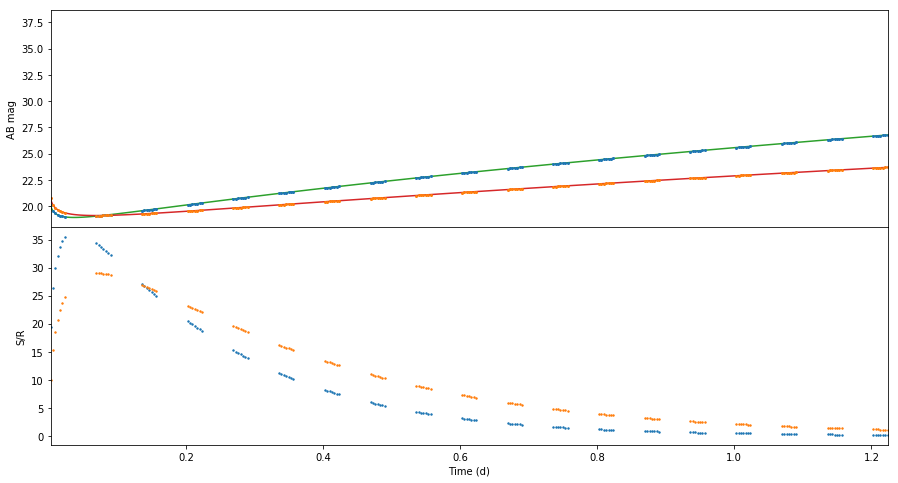

In [4]:
create_and_plot_lc('shock_2.5e10.dat', distance=100e6*u.pc)

Now specifying the observing window...

In [5]:
def plot_realistic_lightcurve(input_lc_file, exposure, label=None, debug=False,  
                              observing_windows=np.array([[0, 30000]]) * u.s, 
                              final_resolution=1200 * u.s, distance=150e6*u.pc):
    # Set debug to True to dump all intermediate images.
    lightcurve_init = \
        get_lightcurve(input_lc_file, exposure=exposure, observing_windows=observing_windows,
                       distance=distance)
    lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=exposure, 
                                                final_resolution=final_resolution, 
                                                debug=debug)
    lightcurve = lightcurve_through_image(lightcurve_init, exposure=exposure, debug=debug)
    
    model_lc_table_fl = QTable(load_model_fluence(input_lc_file,
                                                  dist=distance))
    plt.figure(figsize=(15, 10))
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D1'].to(u.ph / u.cm**2 / u.s).value, label=f"init D1",
             color='r')
    plt.plot(model_lc_table_fl['time'].value / 86400, 
             model_lc_table_fl['fluence_D2'].to(u.ph / u.cm**2 / u.s).value, label=f"init D2",
             color='b')
    
    print(lightcurve_rebin)
    for lc, expo in zip([lightcurve, lightcurve_rebin], [exposure, final_resolution]):
        alpha = 1
        size = 10
        if expo == exposure:
            alpha = 0.3
            size = 5
        good1 = (lc['fluence_D1_fit'] > 0)&(lc['fluence_D1_fiterr'] < lc['fluence_D1_fit'])
        good2 = (lc['fluence_D2_fit'] > 0)&(lc['fluence_D2_fiterr'] < lc['fluence_D2_fit'])
        good = good1&good2
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D1_fit'][good].value, 
                     yerr=lc['fluence_D1_fiterr'][good].value, fmt='o', label=f"D1, {expo}",
                     alpha=alpha, color='r', markersize=size)
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D2_fit'][good].value, 
                     yerr=lc['fluence_D2_fiterr'][good].value, fmt='s', label=f"D2, {expo}",
                     alpha=alpha, color='b', markersize=size)
    plt.xlabel("Time (d)")
    plt.ylabel("Fluence (ph / cm^2 / s)")
    plt.xlim([lightcurve['time'].value.min()/86400, 
              lightcurve['time'].value.max()/86400])
    plt.title(label)
    plt.legend()


  1%|          | 1/112 [00:00<00:21,  5.17it/s]

INFO: Creating images [astroduet.lightcurve]


100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]


  0%|          | 0/15 [00:00<?, ?it/s]

INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


  1%|          | 1/112 [00:00<00:16,  6.94it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/112 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


 69%|██████▉   | 77/112 [00:17<00:07,  4.50it/s]/Users/meo/devel/spyder_projects/duet-astro/astroduet/config.py:509: RuntimeWarning: invalid value encountered in double_scalars
  nint * self.neff * (bgd_rate*texp + self.read_noise**2))**0.5
100%|██████████| 112/112 [00:24<00:00,  4.49it/s]


       time              fluence_D1       ...       snr_D2      
        s               ph / (cm2 s)      ...                   
------------------ ---------------------- ... ------------------
            1657.5  0.0005425639365571598 ... 3.5963191657279068
            8175.0  0.0022383040806570943 ... 11.309403904050967
14215.714285714286   0.002662118981150972 ... 14.935477060579812
           20452.5  0.0025681496982601433 ... 16.276186707885998
           26970.0  0.0022667817687469297 ... 16.517217911354802
           33487.5   0.001904736351902541 ...  16.12676040236736
           40005.0  0.0015573932701356387 ...  15.12314487121288
46307.142857142855  0.0012585941424078427 ... 14.117106666524222
           52282.5  0.0010187254988989311 ... 13.056562790736614
           58650.0  0.0008047558803404048 ... 11.840398702645675
           64410.0   0.000650624177306913 ...  10.26276420979296
           70170.0  0.0005215081192139223 ...  9.265361205728398
           75930.0  0.000

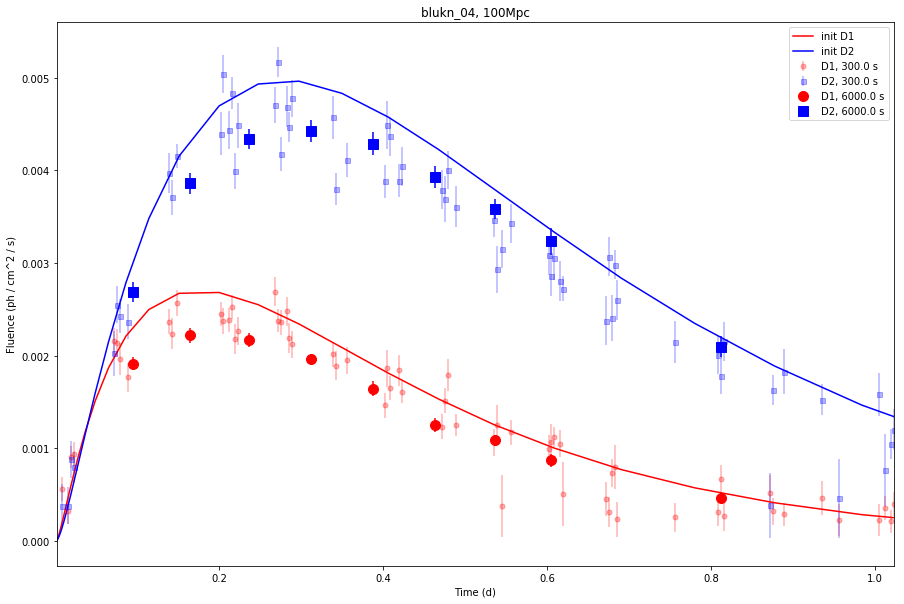

In [6]:
plot_realistic_lightcurve("kilonova_0.04.dat", 300 * u.s,  
                          observing_windows=np.array([[0, 90000]]) * u.s, 
                          final_resolution=6000 * u.s, 
                          distance=100e6*u.pc, label="blukn_04, 100Mpc", debug=True)

In [7]:
## In case someone wants to take a look at the debug images...
## set debug=True in plot_realistic_lightcurves and look at them

def plot_debug_images(directory):
    from astroduet.image_utils import find, run_daophot
    img_pickles = glob.glob(os.path.join(directory, '*.p'))
    for img_pickle in img_pickles:
        with open(img_pickle, 'rb') as fobj:
            img = pickle.load(fobj)
        image1 = img['imgD1']
 
        plt.figure(figsize=(10, 10))
        plt.title(img_pickle)
        plt.imshow(image1.value)
    
# plot_debug_images('debug_imgs_300.0s_12161320/')



  1%|          | 1/112 [00:00<00:16,  6.75it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/32 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


  1%|          | 1/112 [00:00<00:12,  8.88it/s]

INFO: Creating images [astroduet.lightcurve]


  0%|          | 0/112 [00:00<?, ?it/s]

INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


100%|██████████| 112/112 [00:23<00:00,  4.67it/s]


  time        fluence_D1       ...        snr_D1              snr_D2      
   s         ph / (cm2 s)      ...                                        
------- ---------------------- ... ------------------- -------------------
  600.0   0.009497493625423487 ...  28.154624393832577  1.1362787414262074
 1650.0    0.01665426291405152 ...   39.04891682884136   26.04751565948614
 6360.0   0.019898879477331027 ...    43.1826329040562  35.595924641974115
 7410.0    0.01922988069035245 ...   42.53425878546867  35.542534059291754
12120.0   0.015402891755499803 ...  37.170551002174086   34.49369346291259
13170.0   0.014551829932486625 ...   36.37019921932723   34.36172987741306
17880.0    0.01115263740864831 ...  31.572946704337767    32.8695194135183
18930.0   0.010497508813266318 ...  29.667947596629187  31.835985943288886
23640.0   0.007993882115962381 ...  25.719353214001764  29.699762843699965
24690.0   0.007530018943969538 ...   24.00653314070375    28.9742617800247
    ...                  

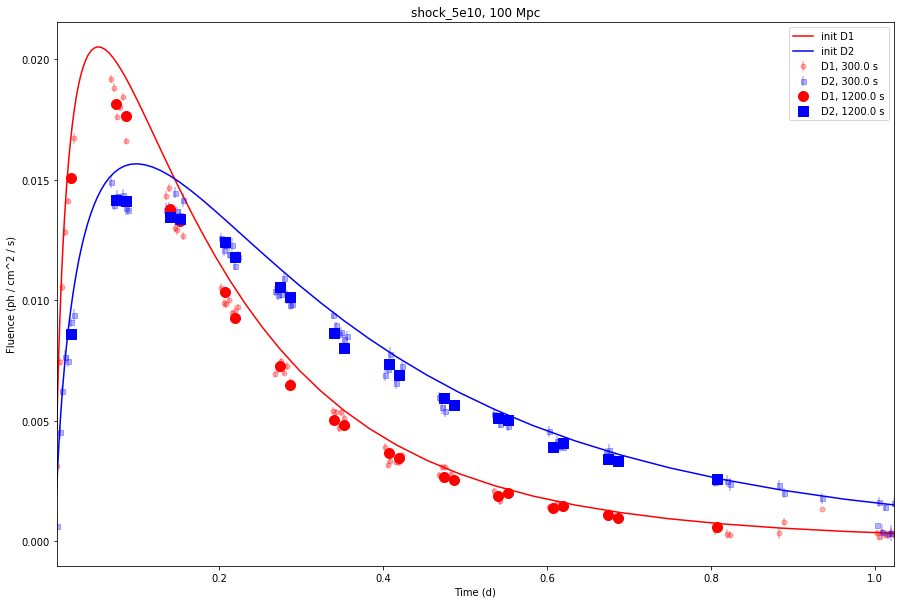

In [8]:
plot_realistic_lightcurve("shock_5e10.dat", exposure=300 * u.s,
                   observing_windows=np.array([[0, 90000]]) * u.s, 
                   distance=100e6*u.pc, 
                   label='shock_5e10, 100 Mpc', debug=False)


In [9]:
def red_chi_sq(f, x, s, dof=None):
    if dof is None:
        dof = len(f) - 1
    return np.sum((f - x)**2 / s**2) / dof


def fit_lightcurve(lightcurve, label='lightcurve fit', solutions=None,
                   debug=False):
    from astroduet.models import Simulations
    from scipy.optimize import curve_fit
    from scipy.interpolate import interp1d
    from astropy.visualization import quantity_support
    quantity_support()
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    snr_D1 = lightcurve['snr_D1']
    snr_D2 = lightcurve['snr_D2']
    good = (fluence_D1 > 0)&(fluence_D2 > 0)&(snr_D1 > 5)&(snr_D1 > 5)
    
    lightcurve = lightcurve[good]
    if len(lightcurve) < 2:
        print("Lightcurve is invalid")
        return solutions
    
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    times = lightcurve['time']
    fluence_D1 = lightcurve['fluence_D1_fit']
    fluence_D2 = lightcurve['fluence_D2_fit']
    fluence_D1_err = lightcurve['fluence_D1_fiterr'] 
    fluence_D2_err = lightcurve['fluence_D2_fiterr'] 

    ratio = fluence_D2 / fluence_D1
    ratio_err = ratio * (fluence_D1_err / fluence_D1 +
                         fluence_D2_err / fluence_D2)

    lc_files = Simulations().emgw_simulations
    if solutions is None:
        solutions = QTable(
            names='model,D1,D2,ratio,D1_chisq,D2_chisq,ratio_chisq,ngood'.split(','), 
            dtype=['U30', float, float, float, float, float, float, int])
    if debug:
        plt.figure(figsize=(15, 15))
        plt.suptitle(label)
        gs = plt.GridSpec(3, 1)
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1], sharex=ax1)
        axr = plt.subplot(gs[2], sharex=ax1)
        ax1.errorbar(times, fluence_D1, yerr=fluence_D1_err, fmt='o', markersize=5)
        ax2.errorbar(times, fluence_D2, yerr=fluence_D2_err, fmt='o', markersize=5)
        axr.errorbar(times, ratio, yerr=ratio_err, fmt='o', markersize=5)

    for lc_file in lc_files:
        model_lc_table_fl = QTable(load_model_fluence(lc_file))
        interpolated_lc_1 = interp1d(model_lc_table_fl['time'].to(u.s).value,
                           model_lc_table_fl['fluence_D1'].value, fill_value=0,
                           bounds_error=False)
        interpolated_lc_2 = interp1d(model_lc_table_fl['time'].to(u.s).value,
                           model_lc_table_fl['fluence_D2'].value, fill_value=0,
                           bounds_error=False)
        def interpolated_lc_ratio(time):
            return(interpolated_lc_2(time) / interpolated_lc_1(time))
    
        def constant_fit_fun_1(x, a):
            return a * interpolated_lc_1(x)
        def constant_fit_fun_2(x, a):
            return a * interpolated_lc_2(x)
        def constant_fit_fun_ratio(x, a):
            return a * interpolated_lc_ratio(x)
        
        par1, pcov1 = curve_fit(constant_fit_fun_1, 
                                times, fluence_D1, 
                                sigma=fluence_D1_err, p0=[1])
        par2, pcov2 = curve_fit(constant_fit_fun_2, 
                                times, fluence_D2, 
                                sigma=fluence_D2_err, p0=[1])
        parr, pcovr = curve_fit(constant_fit_fun_ratio, 
                                times, ratio, sigma=ratio_err, p0=[1])
        
        d1_chisq = red_chi_sq(constant_fit_fun_1(times, *par1), 
                              fluence_D1.value, fluence_D1_err.value, dof=len(fluence_D1) - 1)
        d2_chisq = red_chi_sq(constant_fit_fun_2(times, *par2), 
                              fluence_D2.value, fluence_D2_err.value, dof=len(fluence_D2) - 1)
        ratio_chisq = red_chi_sq(constant_fit_fun_ratio(times, *parr), 
                              ratio.value, ratio_err.value, dof=len(ratio) - 1)
        
        solutions.add_row({'model': lc_file, 'D1': par1, 'D2': par2, 'ratio': parr, 
                           'D1_chisq': d1_chisq, 'D2_chisq': d2_chisq, 'ratio_chisq': ratio_chisq,
                           'ngood': len(fluence_D1)})
        if debug:
            fine_times = np.linspace(times[0], times[-1], 1000)
            ax1.plot(fine_times, 
                     constant_fit_fun_1(fine_times, *par1), label=lc_file)
            ax2.plot(fine_times, 
                     constant_fit_fun_2(fine_times, *par2), label=lc_file)
            axr.plot(fine_times, 
                     constant_fit_fun_ratio(fine_times, *parr), label=lc_file)
    if debug:
        axr.set_ylabel('Flux ratio')
        ax1.legend()
    return solutions


INFO: Creating images [astroduet.lightcurve]
INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


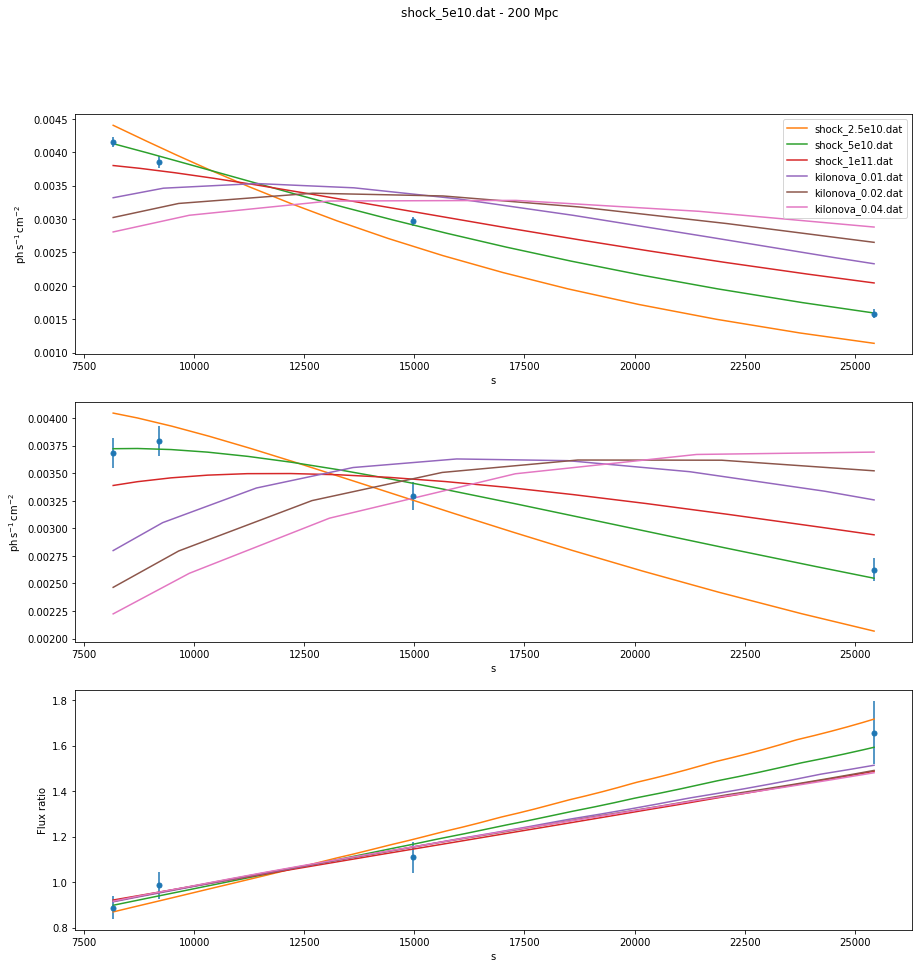

In [10]:
lightcurve_init = \
    get_lightcurve('shock_5e10.dat', exposure=300*u.s,  
                   observing_windows=np.array([[1800, 30000]]) * u.s,
                   distance=200*u.Mpc)
lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=300*u.s, 
                                            final_resolution=1200*u.s, 
                                            silent=True)

solutions = fit_lightcurve(lightcurve_rebin, label='shock_5e10.dat - 200 Mpc', 
                       debug=True)


INFO: Creating images [astroduet.lightcurve]
INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


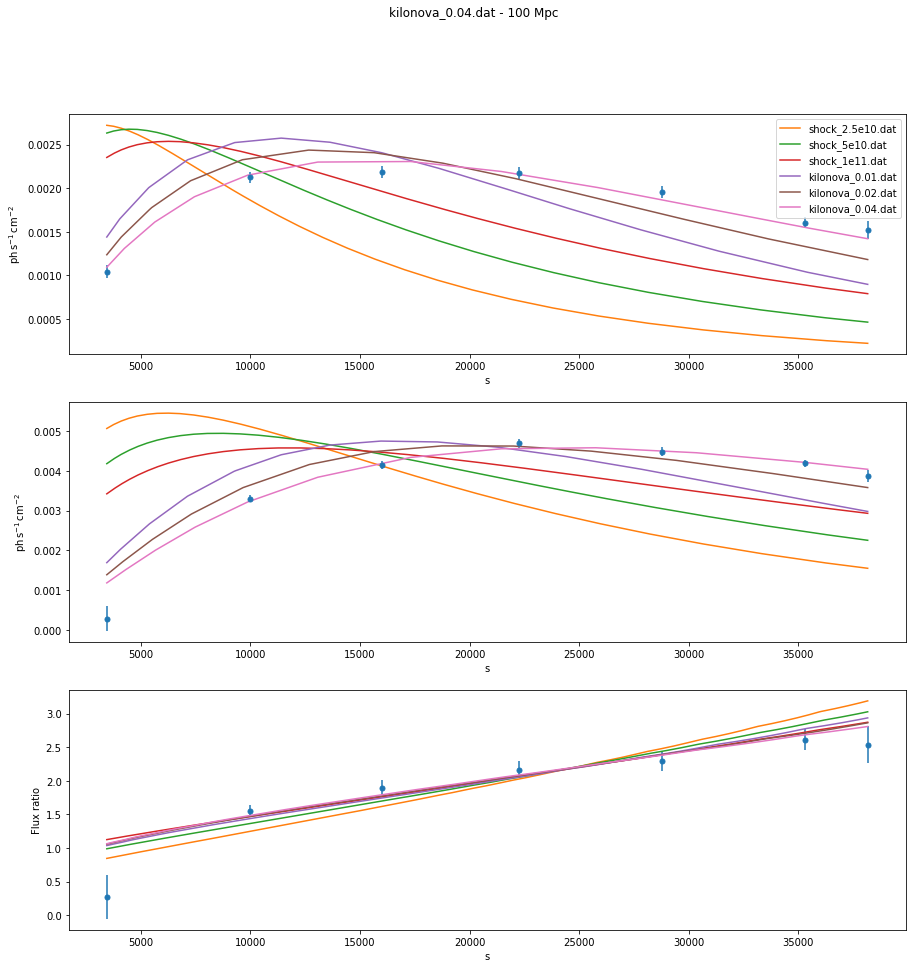

In [11]:
lightcurve_init = \
    get_lightcurve('kilonova_0.04.dat', exposure=300*u.s,  
                   observing_windows=np.array([[1800, 40000]]) * u.s,
                   distance=100*u.Mpc)
lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=300*u.s, 
                                            final_resolution=6000*u.s, 
                                            silent=True)

solutions = fit_lightcurve(lightcurve_rebin, label='kilonova_0.04.dat - 100 Mpc', 
                       debug=True)


In [12]:
def get_rebinned_lightcurve_fit(input_lc_file, exposure, label=None, debug=False,  
                            observing_windows=np.array([[1800, 30000]]) * u.s, 
                            final_resolution=1200 * u.s, distance=100e6*u.pc,
                            ntrial=100):
    import seaborn as sns
    import tqdm
    from astroduet.utils import suppress_stdout
    solutions = None
    for i in tqdm.tqdm(range(ntrial)):
        with suppress_stdout():
            lightcurve_init = \
                get_lightcurve(input_lc_file, exposure=exposure, observing_windows=observing_windows,
                               distance=distance)
           
            lightcurve_rebin = lightcurve_through_image(lightcurve_init, exposure=exposure, 
                                                            final_resolution=final_resolution, 
                                                            debug=debug, silent=True)

        solutions = fit_lightcurve(lightcurve_rebin, label=input_lc_file, solutions=solutions,
                                   debug=False)
    return solutions

------**Uncomment below to produce the data**------

In [19]:
# solutions_sh510_30 = get_rebinned_lightcurve_fit('shock_5e10.dat', exposure=300 * u.s,
#                         observing_windows=np.array([[1800, 30000]]) * u.s,
#                         distance=200 * u.Mpc, ntrial=100)

# sns.pairplot(solutions_sh510_30.to_pandas(), hue='model', diag_kind="kde", vars='D1_chisq,D2_chisq,ratio_chisq'.split(','))
# solutions_sh510_30.write('solutions_sh510.csv', overwrite=True)

Figure description: The fits with low chi squared are systematically those to the correct model (in this case, a shock-type GRB). We generated 30 light curves corresponding to the model `shock_5e10`, at 200 Mpc, starting 30 minutes after the event, and including all instrumental and zodiacal noise sources, and fitted it with all six GW models. The best-fit on the D1 and D2 light curve (as measured from low values of $\chi^2$) is systematically the one corresponding to the correct model.

In [20]:
# solutions_k04 = get_rebinned_lightcurve_fit('kilonova_0.04.dat', exposure=300 * u.s,
#                         observing_windows=np.array([[1800, 40000]]) * u.s,
#                         final_resolution=6000 * u.s,
#                        distance=130*u.Mpc, ntrial=100)
# sns.pairplot(solutions_k04.to_pandas(), hue='model', diag_kind="kde", vars='D1_chisq,D2_chisq,ratio_chisq'.split(','))
# solutions_k04.write('solutions_k04.csv', overwrite=True)

Figure description: Same as previous figure, but this time we simulated 30 lightcurves corresponding to the model `kilonova_0.04`, at 150 Mpc, starting 30 minutes after the event, including all instrumental and zodiacal noise sources, and fitted it with all six GW models. The best-fit on the D1 and D2 light curve (as measured from low values of $\chi^2$), in this case, separates kilonova models from shock GRB models but not much different kilonova models.

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/astropy/io/ascii/connect.py:80: ResourceWarning: unclosed file <_io.TextIOWrapper name='solutions_sh510.csv' encoding='UTF-8'>
  return read(filename, **kwargs)


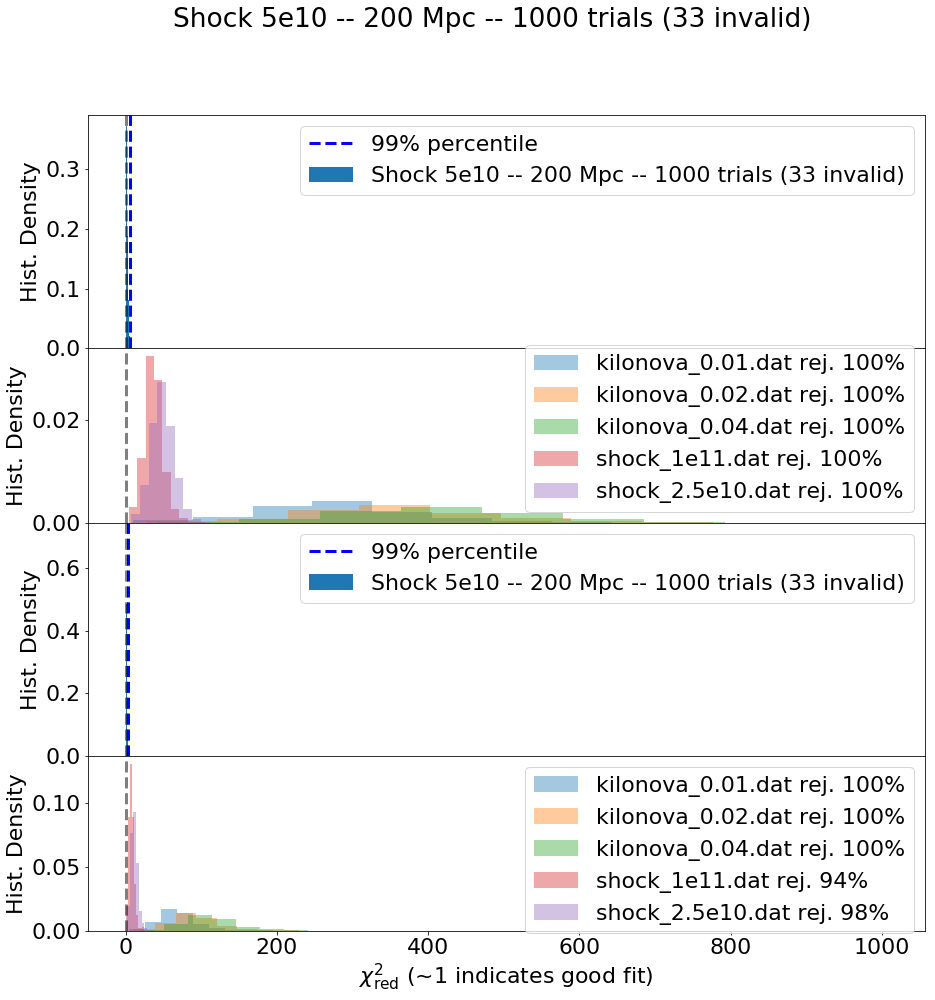

In [21]:
def plot_distributions(solutions, correct, label=None, nbins=10):
    plt.figure(figsize=(15,15))
    plt.suptitle(label)
    gs = plt.GridSpec(4, 1, height_ratios=(4, 3, 4, 3), hspace=0)
    ax11 = plt.subplot(gs[0])
    ax12 = plt.subplot(gs[1], sharex=ax11)
    ax21 = plt.subplot(gs[2], sharex=ax11)
    ax22 = plt.subplot(gs[3], sharex=ax11)
    good = (solutions['D1_chisq'] < 1e32)&(solutions['D2_chisq'] < 1e32)&(solutions['ngood'] >= 4)
    solutions = solutions[good]
    
    if correct is not None:
        ax1 = ax11
        ax2 = ax21
        good = solutions['model'] == correct
        sol = solutions[good]
        per_99_1 = np.percentile(sol['D1_chisq'], 99)
        per_99_2 = np.percentile(sol['D2_chisq'], 99)
        ax1.hist(sol['D1_chisq'], label=label, alpha=1, density=True, 
                 bins=np.linspace(np.min(sol['D1_chisq']), np.max(sol['D1_chisq']), nbins))
        ax2.hist(sol['D2_chisq'], label=label, alpha=1, density=True, 
                 bins=np.linspace(np.min(sol['D2_chisq']), np.max(sol['D2_chisq']), nbins))
        ax1.axvline(per_99_1, ls='--', lw=3, color='b', label='99% percentile')
        ax2.axvline(per_99_2, ls='--', lw=3, color='b', label='99% percentile')
        
    for label in sorted(list(set(solutions['model']))):
        good = solutions['model'] == label
        sol = solutions[good]
        alpha=0.4
        ax1 = ax12
        ax2 = ax22
        if correct is not None and label == correct:
            continue
        rej = np.count_nonzero(sol['D1_chisq'] > per_99_1) / len(sol['D1_chisq'])
        ax1.hist(sol['D1_chisq'], label=label + f' rej. {rej*100:.0f}%', alpha=alpha, density=True, 
                 bins=np.linspace(np.min(sol['D1_chisq']), np.max(sol['D1_chisq']), nbins))
#                  bins=np.logspace(np.log10(np.min(sol['D1_chisq'])), np.log10(np.max(sol['D1_chisq'])), 10))
        rej = np.count_nonzero(sol['D2_chisq'] > per_99_2) / len(sol['D2_chisq'])
        ax2.hist(sol['D2_chisq'], label=label + f' rej. {rej*100:.0f}%', alpha=alpha, density=True, 
                 bins=np.linspace(np.min(sol['D2_chisq']), np.max(sol['D2_chisq']), nbins))
#                  bins=np.logspace(np.log10(np.min(sol['D2_chisq'])), np.log10(np.max(sol['D2_chisq'])), 10))
#         axr.hist(sol['ratio_chisq'], label=label, alpha=alpha, density=True)
    for ax in [ax11, ax12, ax21, ax22]:
#         ax.loglog()
        ax.legend()
        ax.axvline(1, ls='--', lw=3, color='k', alpha=0.5)
        ax.set_ylabel('Hist. Density')
    ax22.set_xlabel(r'$\chi^2_{\rm red}$ (~1 indicates good fit)')
    return

solutions_sh510_30 = Table.read('solutions_sh510.csv')
ntrials = 1000
ngood = len(solutions_sh510_30)//6
plot_distributions(solutions_sh510_30, correct='shock_5e10.dat', 
                   label=f"Shock 5e10 -- 200 Mpc -- {ntrials} trials ({ntrials - ngood} invalid)")

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/astropy/io/ascii/connect.py:80: ResourceWarning: unclosed file <_io.TextIOWrapper name='solutions_k04.csv' encoding='UTF-8'>
  return read(filename, **kwargs)


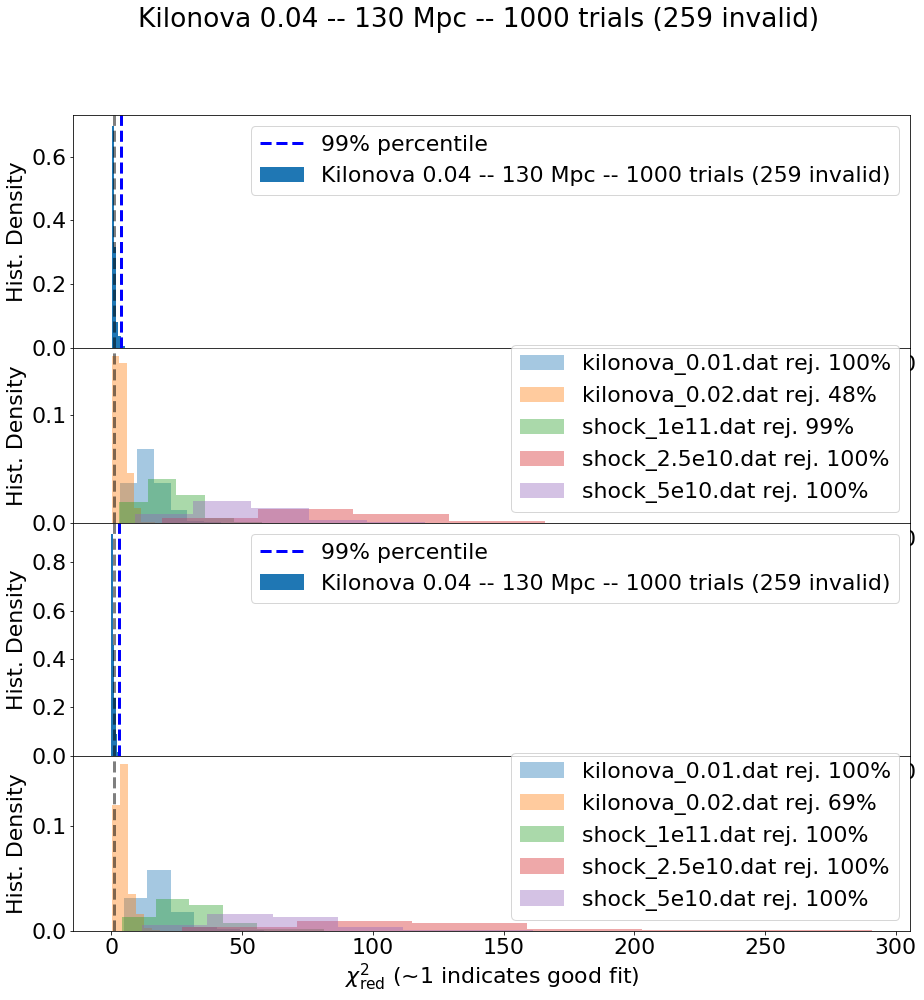

In [22]:
solutions_k04 = Table.read('solutions_k04.csv')
ngood = len(solutions_k04)//6
plot_distributions(solutions_k04, correct='kilonova_0.04.dat', 
                   label=f"Kilonova 0.04 -- 130 Mpc -- {ntrials} trials ({ntrials - ngood} invalid)", nbins=7)